# "Extract potential Corona drug information from literature"
> "Effectiveness of drugs being developed and tried to treat COVID-19 patients."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [corona, jupyter, kaggle, nlp]
- image: images/ner_corona.png
- hide: false
- search_exclude: true

# TOPIC: Effectiveness of drugs being developed and tried to treat COVID-19 patients.


# Introduction

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

## Dataset Description

The CORD-19 dataset represents the most extensive machine-readable coronavirus literature collection available for data mining to date. This allows the worldwide AI research community the opportunity to apply text and data mining approaches to find answers to questions within, and connect insights across, this content in support of the ongoing COVID-19 response efforts worldwide. There is a growing urgency for these approaches because of the rapid increase in coronavirus literature, making it difficult for the medical community to keep up.

*References:   
[https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge](http://)   
COVID-19 Open Research Dataset (CORD-19). 2020. Version 2020-03-13. Retrieved from https://pages.semanticscholar.org/coronavirus-research. doi:10.5281/zenodo.3715506*

In this work we will make use of NLP, text mining, dataframe processing and visualization resources.

# Code development for insights
First, let's import the necessary libraries.  

In [2]:
#hide
# !pip install ipywidgets matplotlib pandas spacy tqdm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz (70.1 MB)
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.2.4-py3-none-any.whl size=70531464 sha256=dd20f1429b9184f219f65b64bf98c4330fd0f64cb81bdbd90a1fd50a89b1dd03
  Stored in directory: /Users/schreibf/Library/Caches/pip/wheels/7c/f4/2d/75a2d2f28a86df956116d40993f5f81df5f5522665c89230eb
Successfully built en-ner-bc5cdr-md


In [3]:
#hide
%%bash -e
if ! [[ -f ./xyz2mol.py ]]; then
  wget https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
fi

In [6]:
#hide
!pip install py3Dmol
!pip install -U chembl_webresource_client
import sys
!conda install --yes --prefix {sys.prefix} -c rdkit rdkit

Requirement already up-to-date: chembl_webresource_client in /Users/schreibf/miniconda3/envs/github_page/lib/python3.7/site-packages (0.10.1)
Solving environment: done

# All requested packages already installed.



In [11]:
#hide
import glob
import json
import pandas as pd
import pickle
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from tqdm import tqdm
import en_ner_bc5cdr_md
import os
from collections import Counter
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol # Amazing library for 3D visualization
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed
from IPython.display import Image
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
import gc

# Load and Clean Data
In this step we will load the data and perform the necessary processing.

## Load Metadata

In [12]:
#hide
def doi_to_url(doi):
    if isinstance(doi, float):
        return None
    elif doi.startswith('http'):
        return str(doi)
    elif doi.startswith('doi'):
        return 'https://' + str(doi)
    else:
        return 'https://doi.org/' + str(doi)

In [46]:
#hide_input
df_meta = pd.read_csv('data/kaggle_covid/metadata.csv')
df_meta['url'] = df_meta.doi.apply(doi_to_url)
df_meta.head(2)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889


## Load articles (JSON Data)

In [14]:
#hide
data_path = 'data/kaggle_covid'
json_files = glob.glob(f'{data_path}/**/**/*.json', recursive=True)
len(json_files)

100125

In [15]:
#hide
def to_covid_json(json_files):
    jsonl = []
    for file_name in tqdm(json_files):
        row = {"doc_id": None, "title": None, "abstract": None, "body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            row['doc_id'] = data['paper_id']
            row['title'] = data['metadata']['title']
            
            abstract_list = [abst['text'] for abst in data['abstract']]
            abstract = "\n".join(abstract_list)
            row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n".join(body_list)
            row['body'] = body
            
        jsonl.append(row)
    
    return jsonl
    

def get_data():
    try:
        with open('df_cache.pickle', 'rb') as f:
            df = pickle.load(f)
    except FileNotFoundError:
        df = pd.DataFrame(to_covid_json(json_files))
        with open('df_cache.pickle', 'wb') as f:
            pickle.dump(df, f)
    return df

df = get_data()
print(df.shape)
df.head(3)

100%|██████████| 100125/100125 [17:31<00:00, 95.23it/s]   


(100125, 4)


,doc_id,title,abstract,body
0,86a998617c077f4fe2ab26214995a3548fbc0fc5,Middle East Respiratory Syndrome and Severe Ac...,The recent emergence of the Middle East respir...,While most CoVs cause the common cold in human...
1,948aaeb2e0be11ad90562bf10d462531a1f00eac,"Integrated, Multi-cohort Analysis Identifies C...",Graphical Abstract Highlights d MVS is a commo...,Clinically relevant respiratory viral signatur...
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,Evolutionary Medicine IV. Evolution and Emerge...,,The evolutionary history of humans is characte...


In [16]:
#hide
df.describe()

,doc_id,title,abstract,body
count,100125,100125,100125,100125
unique,33375,28757,24403,33012
top,429f221d9825a0651b334c8131a6c1d7c96a2208,,,"In previous reports, workers have characterize..."
freq,3,10965,25644,12


All document IDs are unique, nothing to tidy up. But there seem to be missing titles, abstracts and possibly missing bodies.

In [17]:
#hide
def no_title(row):
    return not row.title.strip()

def no_abstract(row):
    return not row.abstract.strip()

def no_body(row):
    return not row.body.strip()

def no_title_abstract_body(row):
    return no_title(row) and no_abstract(row) and no_body(row)

mask = df.apply(no_title_abstract_body, axis=1)
print('Number of articles that have no text data at all:', df.loc[mask].shape[0])

Number of articles that have no text data at all: 0


In [18]:
#hide_input
# insert missing values for empty strings
df.loc[df.apply(no_title, axis=1), 'title'] = None
df.loc[df.apply(no_abstract, axis=1), 'abstract'] = None
df.loc[df.apply(no_body, axis=1), 'body'] = None
df.head(3)

,doc_id,title,abstract,body
0,86a998617c077f4fe2ab26214995a3548fbc0fc5,Middle East Respiratory Syndrome and Severe Ac...,The recent emergence of the Middle East respir...,While most CoVs cause the common cold in human...
1,948aaeb2e0be11ad90562bf10d462531a1f00eac,"Integrated, Multi-cohort Analysis Identifies C...",Graphical Abstract Highlights d MVS is a commo...,Clinically relevant respiratory viral signatur...
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,Evolutionary Medicine IV. Evolution and Emerge...,None,The evolutionary history of humans is characte...


In [19]:
#hide
print('Missing value counts by column')
len(df) - df.count()

Missing value counts by column


doc_id          0
title       10965
abstract    25644
body            0
dtype: int64

In [20]:
#hide
# Gabarge collector
import gc
gc.collect()

0

We will be working with abstracts. They provide an appropriate level of detail for the question at hand. Thus, we will drop all documents that do not have an abstract.

In [21]:
#hide
df = df.dropna(subset=['abstract'])
print('DataFrame shape:', df.shape)
len(df) - df.count()

DataFrame shape: (74481, 4)


doc_id         0
title       2910
abstract       0
body           0
dtype: int64

# Pre-filter by COVID-19
In order to analyze the papers related to COVID-19, we will create specific filters.

In [22]:
#hide
covid19_names = {
    'COVID19',
    'COVID-19',
    '2019-nCoV',
    '2019-nCoV.',
#     'novel coronavirus',  # too ambiguous, may mean SARS-CoV
    'coronavirus disease 2019',
    'Corona Virus Disease 2019',
    '2019-novel Coronavirus',
    'SARS-CoV-2',
}

def has_covid19(text):
    for name in covid19_names:
        if text and name.lower() in text.lower():
            return True
    return False

df['title_has_covid19'] = df.title.apply(has_covid19)
df['abstract_has_covid19'] = df.abstract.apply(has_covid19)
# df['body_has_covid19'] = df.body.apply(has_covid19)
df_covid19 = df[df.title_has_covid19 | df.abstract_has_covid19]
print(df_covid19.shape)

(3312, 6)


# Apply Scispacy Model

We use Scispacy's `en_ner_bc5cdr_md`. It provides only two NER classes: `DISEASE` and `CHEMICAL`. We are mostly interested in the latter because this class will likely carry drugs and therapeutics.

In [23]:
#hide
example_text = """
Unfortunately, no drug or vaccine has yet been approved to treat human coronaviruses. Several options can be envisaged to control or prevent emerging infections of 2019-nCoV, including vaccines, monoclonal antibodies, oligonucleotide-based therapies, peptides, interferon therapies and small-molecule drugs. However, new interventions are likely to require months to years to develop. Given the urgency of the 2019-nCoV outbreak, we focus here on the potential to repurpose existing antiviral agents approved or in development for treating infections caused by HIV, hepatitis B virus (HBV), hepatitis C virus (HCV) and influenza1, based on therapeutic experience with two other infections caused by human coronaviruses: severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS).
Virally targeted agents. Approved nucleoside analogues (favipiravir and ribavirin) and experimental nucleoside analogues (remdesivir and galidesivir) may have potential against 2019-nCoV. Nucleoside analogues in the form of adenine or guanine derivatives target the RNA-dependent RNA polymerase and block viral RNA synthesis in a broad spectrum of RNA viruses, including human coronaviruses4. Favipiravir (T-705), a guanine analogue approved for influenza treatment, can effectively inhibit the RNA-dependent RNA polymerase of RNA viruses such as influenza, Ebola, yellow fever, chikungunya, norovirus and enterovirus4, and a recent study reported its activity against 2019-nCoV (EC50 = 61.88 μM in Vero E6 cells)5. Patients with 2019-nCoV are being recruited in randomized trials to evaluate the efficacy of favipiravir plus interferon-α (ChiCTR2000029600) and favipiravir plus baloxavir marboxil (an approved influenza inhibitor targeting the cap-dependent endonuclease) (ChiCTR2000029544). Ribavirin is a guanine derivative approved for treating HCV and respiratory syncytial virus (RSV) that has been evaluated in patients with SARS and MERS, but its side effects such as anaemia may be severe at high doses2 and whether it offers sufficient potency against 2019-nCoV is uncertain. Remdesivir (GS-5734) is a phosphoramidate prodrug of an adenine derivative with a chemical structure similar to that of tenofovir alafenamide, an approved HIV reverse transcriptase inhibitor. Remdesivir has broad-spectrum activities against RNA viruses such as MERS and SARS in cell cultures and animal models, and has been tested in a clinical trial for Ebola. A recent study reported that remdesivir inhibited 2019-nCoV (EC50 = 0.77 μM in Vero E6 cells)5, and a US patient with 2019-nCoV recovered after receiving intravenous remdesivir in January6. Two phase III trials were initiated in early February to evaluate intravenous remdesivir (200 mg on day 1 and 100 mg once daily for 9 days) in patients with 2019-nCoV (NCT04252664 and NCT04257656), with estimated completion dates in April 2020. Galidesivir (BCX4430), an adenosine analogue that was originally developed for HCV, is currently in early-stage clinical studies evaluating its safety in healthy subjects and its efficacy against yellow fever, and has shown antiviral activities in preclinical studies against many RNA viruses, including SARS and MERS2.
"""

In [47]:
nlp = en_ner_bc5cdr_md.load()
# nlp = spacy.load('../input/scispacy-model/en_ner_bc5cdr_md-0.2.4/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.2.4')
doc = nlp(example_text)
colors = {
    'CHEMICAL': 'lightpink',
    'DISEASE': 'lightorange',
}
displacy.render(doc, style='ent', options={
    'colors': colors
})

In [48]:
#hide
def apply_spacy(texts, nlp):
    docs = []
    for t in texts:
        if t:
            docs.append(nlp(t))
        else:
            docs.append(None)
    return docs

In [28]:
#hide
def annotate_with_spacy(df):
    df['title_doc'] = apply_spacy(df.title, nlp)
    df['abstract_doc'] = apply_spacy(df.abstract, nlp)
    return df

def get_spacy_df(df):
    try:
        with open('df_spacy_cache.pickle', 'rb') as f:
            df_spacy = pickle.load(f)
    except FileNotFoundError:
        df_spacy = annotate_with_spacy(df)
        with open('df_spacy_cache.pickle', 'wb') as f:
            pickle.dump(df_spacy, f)
    return df_spacy

In [49]:
#hide
df_spacy = get_spacy_df(df_covid19)
df_spacy.iloc[0].abstract_doc.ents

(M. -Infections virales,)

# Match relevant tokens, e.g. COVID-19, trial and usage indicators
We will now perform the necessary processing to make it possible to carry out the analyzes of interest.


In [30]:
#hide
trial_indicators = {
    'trial',
    'study',
    'experiment',
    'evaluate',
    'evaluation',
    're-evaluate',
    'report',
    'test',
    'testing',
    'target',
    'data',
    'show',
    'outcome',
    'evaluation',
    'find',
    'agent',
    
}

usage_indicators = {
    'approve',
    'approval',
    'therapeutic',
    'therapy',
    'inhibitory',
    'effect',
    'administer',
    'achieve',
    'improve'
    'alleviate',
    'reduce',
    'antiviral',
    'against',
    'suppress',
    'beneficial',
    'evidence',
    'take',
	'prescribe',
	'treatment',
	'receive',
	'treat',
	'regimen',
	'therapy',
	'use',
	'efficacy',
	'course',
	'drug',
}

idea_indicators = {
    'promising',
    'promise',
    'speculate',
    'believe',
    'would',
    'could',
    'may',
    'possibly',
    'might',
    'should',
    'hypothesize',
    'appear',
    'lack',
    'unclear',
    'need',
} 

matcher = Matcher(nlp.vocab)
for n in trial_indicators:
    matcher.add("trial", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in usage_indicators:
    matcher.add("usage", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in idea_indicators:
    matcher.add("idea", None, [{'LEMMA': w.lemma_} for w in nlp(n)])

example_sent = "Clinical trials (for example, ChiCTR2000029539) have been initiated to test HIV protease inhibitors such as lopinavir and ritonavir in patients infected with 2019-nCoV."
doc = nlp(example_sent)
matches = matcher(doc)
for match_name, start, end in matches:
    print(nlp.vocab.strings[match_name], ':', doc[start:end])

trial : trials
trial : test


In [31]:
#hide_input
def doc_to_matches(doc):
    match_results = {
        'trial': [],
        'usage': [],
        'idea': []
    }
    if not doc:
        return match_results

    matches = matcher(doc)
    for match_id, start, end in matches:
        match_name = nlp.vocab.strings[match_id]
        match_results[match_name].append((start, end))
    return match_results

def get_matches_df(docs):
    matches = []
    for doc in docs:
        matches.append(doc_to_matches(doc))
    df = pd.DataFrame(matches)
    return df
        
df_matches = get_matches_df(df_spacy.abstract_doc)
df_matches.columns = ['abstract_trial_matches', 'abstract_usage_matches', 'abstract_idea_matches']
df_with_matches = pd.concat([df_spacy.reset_index(drop=True), df_matches], axis=1)
df_with_matches.head(3)

,doc_id,title,abstract,body,title_has_covid19,abstract_has_covid19,title_doc,abstract_doc,abstract_trial_matches,abstract_usage_matches,abstract_idea_matches
0,acd84940fc5cd8e8f54efd04ab672f5afbd2d7df,None,"publicly funded repositories, such as the WHO ...","Les infections respiratoires ~t rhinovirus, pa...",False,True,None,"(publicly, funded, repositories, ,, such, as, ...",[],[],[]
1,e0ea1ef905ee29982a58399b858842a8e212116e,"Alternativ Cefoxitin (▶ 18.2.2), Amoxicillin m...","publicly funded repositories, such as the WHO ...","Obligat intrazelluläre, zellwandlose Bakterien...",False,True,"(Alternativ, Cefoxitin, (, ▶, 18.2.2, ), ,, Am...","(publicly, funded, repositories, ,, such, as, ...",[],[],[]
2,8605e1247b39f6fa0d909b356eb198aacd09843c,Modeling the dynamics of novel coronavirus (20...,The present paper describes the mathematical m...,One of the greatest assignments given to human...,True,True,"(Modeling, the, dynamics, of, novel, coronavir...","(The, present, paper, describes, the, mathemat...","[(162, 163)]","[(94, 95)]","[(63, 64)]"


# Example Articles that talk about COVID-19

In [32]:
#hide_input
# df_covid19 = df_with_matches[df_with_matches.abstract_has_covid19]
print('Example abstracts', df_with_matches.shape)
for i, row in list(df_with_matches.iterrows())[:5]:
    print('TITLE:', row.title)
    print('\n')
    print(row.abstract)
    print('\n', '-' * 50, '\n')

Example abstracts (3312, 11)
TITLE: None


publicly funded repositories, such as the WHO COVID database with rights for unrestricted research re-use and analyses in any form or by any means with acknowledgement of the original source. These permissions are granted for free by Elsevier for as long as the COVID-19 resource centre remains active. RADERMECKER M. -Infections virales et asthme. Rev. ft.

 -------------------------------------------------- 

TITLE: Alternativ Cefoxitin (▶ 18.2.2), Amoxicillin mit BetalaktamaseHemmer


publicly funded repositories, such as the WHO COVID database with rights for unrestricted research re-use and analyses in any form or by any means with acknowledgement of the original source. These permissions are granted for free by Elsevier for as long as the COVID-19 resource centre remains active. 624 17 Infektionen 17.2 Bakterielle Infektionen (Auswahl) 17.2.1 Aktinomyzetales (Strahlenpilzkrankheit) Ätiologie Actinomyces israelii wird endogen, z. B. durch k

# Extract all drugs and therapeutics from abstracts
Drop all chemicals that appear less than N times in the whole dataset.
In the remaining, blacklist all false positives after manual inspection. Plot the remaining chemicals by occurrence frequency.

Count Frequencies

{'angiotensin': 39, 'trypsin': 39, 'CP': 33, 'chloroquine': 33, 'lopinavir/ritonavir': 30, 'ritonavir': 30, 'SARS-CoV2': 27, 'triphosphate': 27, 'creatinine': 24, 'methylprednisolone': 24, 'lopinavir': 24, 'SARS-COV-2': 21, 'TCB': 21, 'amphotericin B': 21, 'hydroxychloroquine': 21, 'NBCZone': 21, 'corticosteroids': 18, 'Sofosbuvir': 18, 'ciclesonide': 18, 'alanine': 15, 'melatonin': 15, 'cefotaxime': 15, 'ceftazidime': 15, 'cefepime': 15, 'Nucleocapsid': 15, 'ribavirin': 15, 'nucleic acids': 15, 'darunavir': 15, 'HK': 15, 'sodium': 12, 'luminal': 12, 'ampicillin': 12, 'fluticasone': 12, 'Angiotensin': 12, 'Linezolid': 12, 'Renin-Angiotensin': 12, 'cortisol': 12, 'oseltamivir': 12, 'ACE2s': 12, 'SARS-CoV-2 infections': 12, 'mercaptopurine': 12, 'sirolimus': 12, 'Alovudine': 12, 'AZT': 12, 'heparan sulfate': 12, 'epitope-encoding amino acids': 12, 'teicoplanin': 12, 'CPM': 12, 'moxifloxacin': 9, 'chlorhexidine': 9, 'Remdesivir': 9, 'angiotensin II': 9, 'bilirubin': 9, 

<BarContainer object of 72 artists>

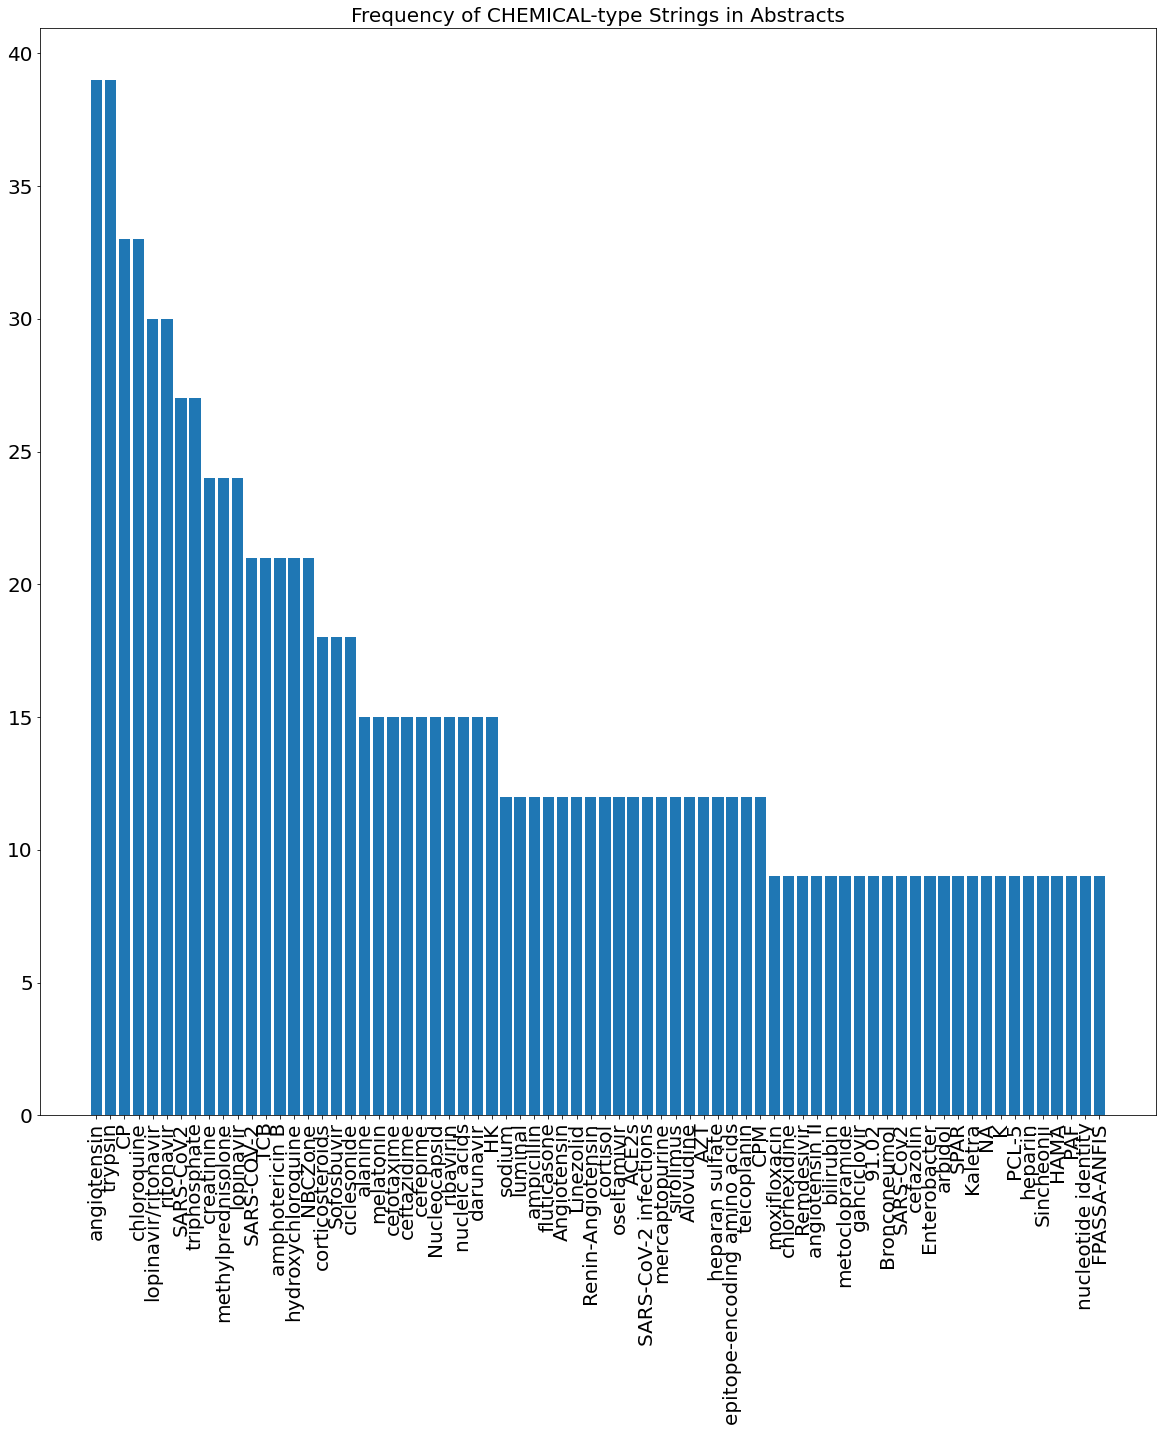

In [33]:
#hide
BLACKLIST = {
 '2019-nCoV',
 '95%CI',
 'ACE2-Fc',
 'AMB',
 'AMI',
 'AMK',
 'AOM',
 'AST-045',
 'AST-N041',
 'ATP',
 'BPO3-P',
 'Betacoronavirus',
 'CAP',
 'CAZ',
 'CC',
 'CIP',
 'CLAVE',
 'COVID-2019',
 'CR3022',
 'CTX',
 'CTX-M',
 'CoV-2',
 'DES',
 'DHPG',
 'DIP',
 'E2',
 'ESBL',
 'Enterobacteriaceae',
 'FASTA',
 'FCA',
 'FCS',
 'FOS',
 'GEN',
 'GM',
 'HPDI',
 'IFR',
 'IM',
 'IVA',
 'JA',
 'KLK13',
 'LA',
 'LPV/r',
 'LYM%',
 'La',
 'LcS',
 'Li',
 'MERS-CoV.',
 'MICs',
 'Metapneumovirus',
 'Médecine',
 'NAL',
 'NCP',
 'NG',
 'NLR',
 'NO',
 'NOR',
 'NP',
 'NS7b',
 'OC',
 'OFL',
 'OP',
 'Prefixes',
 'Résumé',
 'S.',
 'SARS-CoV-2',
 'SARS-CoV-2 infection',
 'SARS-CoV-2 pneumonia',
 'SARS-CoV.',
 'SARS-Cov-2',
 'SARS-related',
 'SGC7901',
 'SHV',
 'SP',
 'Sarbecovirus',
 'Se',
 'TCM',
 'TCR',
 'TGEV',
 'TOB',
 'TSL-EO',
 'Texte',
 'VME',
 'VP',
 'WeChat',
 'ZJ01',
 '[ST]A',
 'alcohol',
 'amino acid',
 'amino acids',
 'aminoglycosides',
 'bat-SL-CoVZXC21',
 'betacoronavirus',
 'cholesterol',
 'coronavirus',
 'des cas',
 'https://doi.org/10',
 'infector-infectee',
 "l'origine",
 'lactate',
 'lockdowns',
 'na',
 'nucleic acid',
 'nucleotide',
 'oxygen',
 'quinolones',
 'rinitis',
 'self-imposed',
 'smoking',
 'β-coronavirus',
 '℃'}


def count_chemical_ents(df):
    ent_str = []
    for i, row in df.iterrows():
        if row.abstract_doc:            
            for ent in row.abstract_doc.ents:
                if ent.label_ == 'CHEMICAL':
                    ent_str.append(row.abstract_doc[ent.start:ent.end].text)
            
    filtered = [e for e in Counter(ent_str).most_common() if e[1] > 8 and e[0] not in BLACKLIST]
    return dict(filtered)

counts = count_chemical_ents(df_with_matches)
print('Count Frequencies\n')
print(counts)

plt.figure(figsize=(20,20))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xticks(rotation=90)
plt.title('Frequency of CHEMICAL-type Strings in Abstracts', fontsize=20)
plt.bar(counts.keys(), counts.values())

# Simple Concordance Visualiser
Helps to compile the above blacklist as well as see contexts in which the above drug names appear.

In [34]:
#hide_input
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.core.display import HTML

HTML_WRAPPER = """<div style="overflow-x: auto; border: 1px solid #e6e9ef; border-radius: 0.25rem; padding: 1rem; margin-bottom: 2.5rem">{}</div>"""
BEGIN_ENTITY = """<mark class="entity" style="background: lightpink; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY = """</mark>"""

def match_to_concordance_html(match, doc, window_size=15):
    _, start, end = match
    concordance_start = max(start - window_size, 0)
    concordance_end = min(end + window_size, len(doc))
    return doc[concordance_start:start].text + BEGIN_ENTITY + doc[start:end].text + END_ENTITY + doc[end:concordance_end].text + '</br></br>'

@interact_manual
def show_articles_more_than(column='abstract_doc', query='darunavir'):
    matcher = Matcher(nlp.vocab)
    matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(query)])
    result = []
    html_str = ''
    for doc in df_with_matches[column]:
        if not doc:
            continue
        matches = matcher(doc)
        for match in matches:
            html_str += match_to_concordance_html(match, doc)
    return display(HTML(HTML_WRAPPER.format(html_str + ''))) ##

interactive(children=(Text(value='abstract_doc', description='column'), Text(value='darunavir', description='q…

# Organise matches by Drugs/Therapeutics
Above, we compiled a list of drugs/therapeutics that are relevant in the context of COVID-19. Now, we can dive deeper into the contexts these drugs appear in.

To this end, we match words that indicate the context of the drug mention:
* drug is in an **idea stage** (e.g. 'darunavir could be useful against COVID-19')
* drug is in a **trial stage** (e.g. 'lopinavir is currently being trialled')
* drug is in **usage stage** (e.g. 'patients are being treated with ritonavir')

These 'indicator' words are marked as additional entities in context.

In [35]:
#hide_input
def doc_id_to_link(doc_id, df_meta, df_data):
    rows = df_meta[df_meta.sha == doc_id]
    if rows.empty:
        return 'UNKNOWN URL AND TITLE'
    url = rows.iloc[0].url
    title = rows.iloc[0].title
    if url and title:
        return '<a href="{}">'.format(url) + title + '</a>'
    elif title:
        return title
    elif url:
        return '<a href="{}">'.format(url) + 'UNKNOWN TITLE' + '</a>'
    else:
        return 'UNKNOWN URL AND TITLE'

def chemical_df(chemicals, df_data, df_meta):
    rows = []    
    for chem in chemicals:
        chem_row = {
            'chemical_name': chem,
            'chemical': [],
            'trials': [],
            'usages': [],
            'ideas': []
        }
        matcher = Matcher(nlp.vocab)
        matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(chem)])
        for i, row in df_data.iterrows():
            chem_matches = matcher(row.abstract_doc)
            for chem_match in chem_matches:
                chem_row['chemical'].append((row.doc_id, chem_match[1], chem_match[2]))
                for trial_match in row.abstract_trial_matches:
                    if abs(trial_match[1] - chem_match[1]) < 15:
                        chem_row['trials'].append((row.doc_id, trial_match[0], trial_match[1]))
                for usage_match in row.abstract_usage_matches:
                    if abs(usage_match[1] - chem_match[1]) < 15:
                        chem_row['usages'].append((row.doc_id, usage_match[0], usage_match[1]))
                for idea_match in row.abstract_idea_matches:
                    if abs(idea_match[1] - chem_match[1]) < 15:
                        chem_row['ideas'].append((row.doc_id, idea_match[0], idea_match[1]))
        rows.append(chem_row)
    return pd.DataFrame(rows)
        
    
df_chemical = chemical_df(list(counts.keys()), df_with_matches, df_meta)
df_chemical.head(3)

,chemical_name,chemical,trials,usages,ideas
0,angiotensin,"[(ff18efb2e82ebc22ce76fca5552489439cf48ef1, 19...","[(c672f5b0d7c0a40f7cc1bdf079066d72eb8f64ec, 41...","[(ff18efb2e82ebc22ce76fca5552489439cf48ef1, 18...","[(5b4707dbb9908080a2368e45298982ef80cc8c68, 38..."
1,trypsin,"[(6160b70c9ba139ee9e4b2accd40954bec9b46f07, 61...","[(6160b70c9ba139ee9e4b2accd40954bec9b46f07, 12...","[(6160b70c9ba139ee9e4b2accd40954bec9b46f07, 11...","[(6160b70c9ba139ee9e4b2accd40954bec9b46f07, 10..."
2,CP,"[(8a6d8754a8f644b6decc50b0ea53493105d21ac5, 14...",[],[],[]


## Code for highlight  the text

In [36]:
#hide_input
LABEL_TO_COLOUR = {
    'chemical': 'lightorange',
    'trials': 'lightpink',
    'usages': 'lightgreen',
    'ideas': 'lightblue'
}
BEGIN_ENTITY = """<mark class="entity" style="background: {}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY_WITH_SUBSCRIPT = """<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">{}</span>\n</mark>"""

def get_ents_by_doc_id(row):
    contexts={'chemical', 'trials', 'usages', 'ideas'}
    ents_by_doc_id = {}
    for c in contexts:
        for doc_id, start, end in row[c]:
            entry = (start, end, c)
            if doc_id not in ents_by_doc_id:
                ents_by_doc_id[doc_id] = [entry]
            else:
                ents_by_doc_id[doc_id].append(entry)
    return ents_by_doc_id

@interact
def show_articles_for_chemical(chemical=list(counts.keys())):
    row = df_chemical[df_chemical['chemical_name'] == chemical].iloc[0]
    ents_by_doc_id = get_ents_by_doc_id(row)
    html = ''
    for doc_id, ents in ents_by_doc_id.items():
        doc = df_with_matches[df_with_matches.doc_id == doc_id].iloc[0].abstract_doc
        sorted_ents = sorted(set(ents))
        doc_html = doc_id_to_link(doc_id, df_meta, df_covid19) + '</br></br>' 
        prev_end = 0
        for start, end, label in sorted_ents:
            doc_html += doc[prev_end:start].text
            doc_html += ' ' + BEGIN_ENTITY.format(LABEL_TO_COLOUR[label]) + doc[start:end].text + END_ENTITY_WITH_SUBSCRIPT.format(label) + ' '
            prev_end = end
        doc_html += doc[end:].text + '</br></br>'
        html+=doc_html
        

    return display(HTML(html))

interactive(children=(Dropdown(description='chemical', options=('angiotensin', 'trypsin', 'CP', 'chloroquine',…

# Molecular Structure
## Clustering the cited compounds 
In this routine we will group the top cited compounds in clusters according to their molecular structure.
Here we use PCA to reduce dimensionality and create a cluster with kmeans algorithm.

In [37]:
#hide
# function to draw the molecule
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
p = py3Dmol.view(width=400,height=400)

In [38]:
#hide
# get the top drugs most mencioned
listchemicals = df_chemical.chemical_name.head(30)

listMols2 = []
listValids = []

for i in range(len(listchemicals)):
    try:
        productName = listchemicals[i]
        
        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        listMols2.append(m)
        listValids.append(productName)
      
    except Exception as e:
        print(f'\nSorry, impossible to create structure for {productName}.')
        
        
# generate fingeprints: Morgan fingerprint with radius 2
n_dimensions = 300
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, n_dimensions) for m in listMols2]
# Convert to numpy array
np_fps = np.asarray(fps)

############# PCA decomposition (n=3)  #######################
centers = [[1, 1], [-1, -1], [1, -1]]
X = np_fps
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
df2 = pd.DataFrame(X ,columns=['principal_component_1','principal_component_2','principal_component_3'])
df2['names'] = pd.DataFrame(listValids)

############# Kmeans clusters  #######################
kmeansmodel = KMeans(n_clusters=8).fit(df2[df2.columns[0:3]])
labelKmeans = kmeansmodel.labels_.astype(float)
df2['cluster'] = labelKmeans


Sorry, impossible to create structure for trypsin.

Sorry, impossible to create structure for CP.

Sorry, impossible to create structure for SARS-COV-2.

Sorry, impossible to create structure for NBCZone.

Sorry, impossible to create structure for Nucleocapsid.

Sorry, impossible to create structure for nucleic acids.

Sorry, impossible to create structure for HK.


In [39]:
#hide
# Remove duplicated compounds
df2 = df2.drop_duplicates(subset=['principal_component_1','principal_component_2','principal_component_3'])
df2.drop( df2[ df2['names'] == 'SARS-CoV2' ].index , inplace=True)
df2.sort_values(by=['cluster'])

,principal_component_1,principal_component_2,principal_component_3,names,cluster
19,-3.258671,-4.252607,-0.516005,cefepime,0.0
18,-3.675826,-3.761109,-0.515816,ceftazidime,0.0
17,-2.848375,-3.841486,-0.982743,cefotaxime,0.0
10,2.394829,-0.469721,-1.202516,amphotericin B,1.0
13,2.074839,0.215181,-0.899628,Sofosbuvir,1.0
8,-0.629882,1.383539,-1.014856,lopinavir,2.0
21,-1.389553,1.557973,-0.652427,darunavir,2.0
7,3.107877,-1.386418,-2.439476,methylprednisolone,3.0
12,3.805803,-1.005147,-2.775181,corticosteroids,3.0
14,3.578985,-1.394869,-2.879403,ciclesonide,3.0


In [40]:
#hide
# Garbage collector to liberate memory
gc.collect()

0

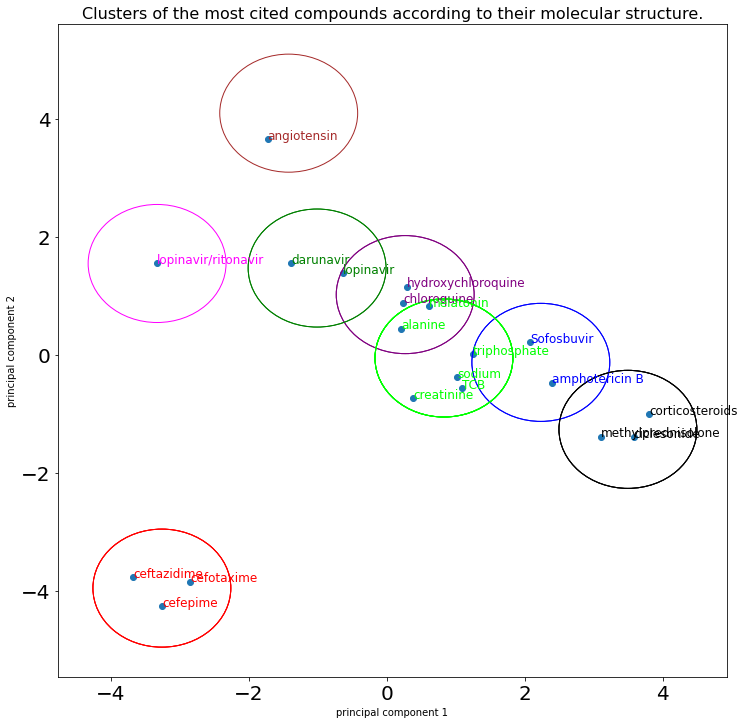

In [41]:
#hide_input
############# Scatter plot  #######################
import matplotlib.patches as mpatches

centroids  = kmeansmodel.cluster_centers_

def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

xs = df2.principal_component_1
ys = df2.principal_component_2
names = df2.names
cluster = df2.cluster
ax.scatter(xs, ys)

for x,y,names,cluster in zip(xs,ys,names,cluster):
    label = names
    if cluster == 0:
        ax.text(x, y, label, fontsize=12, color='red')
        art = mpatches.Circle(centroids[0],1, edgecolor='r',fill=False)
        ax.add_patch(art)
    if cluster == 1:
        ax.text(x, y, label,fontsize=12, color='blue')
        art = mpatches.Circle(centroids[1],1, edgecolor='blue',fill=False)
        ax.add_patch(art)        
    if cluster == 2:
        ax.text(x, y, label, fontsize=12, color='green')
        art = mpatches.Circle(centroids[2],1, edgecolor='green',fill=False)
        ax.add_patch(art)        
    if cluster == 3:
        ax.text(x, y, label, fontsize=12, color='black') 
        art = mpatches.Circle(centroids[3],1, edgecolor='black',fill=False)
        ax.add_patch(art)        
    if cluster == 4:
        ax.text(x, y, label, fontsize=12, color='purple')
        art = mpatches.Circle(centroids[4],1, edgecolor='purple',fill=False)
        ax.add_patch(art)        
    if cluster == 5:
        ax.text(x, y, label, fontsize=12, color='lime') 
        art = mpatches.Circle(centroids[5],1, edgecolor='lime',fill=False)
        ax.add_patch(art)        
    if cluster == 6:
        ax.text(x, y, label, fontsize=12, color='brown') 
        art = mpatches.Circle(centroids[6],1, edgecolor='brown',fill=False)
        ax.add_patch(art)        
    if cluster == 7:
        ax.text(x, y, label, fontsize=12, color='magenta')  
        art = mpatches.Circle(centroids[7],1, edgecolor='magenta',fill=False)
        ax.add_patch(art)        
    
      

ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.title('Clusters of the most cited compounds according to their molecular structure.', loc='center', pad=None, fontSize=16)
plt.show()

We can clearly see the separation of compounds groups.
The most important of which are: antiretroviral protease inhibitors, corticosteroids, polyene antibiotics, glycosaminoglycans heparan sulfate, proteases and aminoquinoline derivatives.
Note: It was checked on Pubchem database.

Public References:  (In case of doubt to which chemical class a certain compound belongs, you can consult the public database PubChem )   
https://pubchem.ncbi.nlm.nih.gov  
https://pubchem.ncbi.nlm.nih.gov/compound/392622  
https://pubchem.ncbi.nlm.nih.gov/compound/5755  
https://pubchem.ncbi.nlm.nih.gov/compound/213039  
https://pubchem.ncbi.nlm.nih.gov/compound/70678539  
https://pubchem.ncbi.nlm.nih.gov/compound/5479537   
https://pubchem.ncbi.nlm.nih.gov/compound/Amphotericin%20B

## Printing and comparing molecular structures

Now we will print and compare those mentioned with other drugs with similar molecular structures in the public ChEMBL database. 
You can find more information about the database on [https://www.ebi.ac.uk/chembl/](http://)

Note: If you want to zoom in, or rotate de molecule, just click, scroll and move the mouse inside the molecule picture.
Note 2: We will select only few compounds.

In [42]:
#hide_input
# get the top drugs most mencioned
listchemicals = df_chemical.chemical_name.head(5)
listchemicals

0            angiotensin
1                trypsin
2                     CP
3            chloroquine
4    lopinavir/ritonavir
Name: chemical_name, dtype: object


..................................................................................

Structure of angiotensin



interactive(children=(IntSlider(value=-1, description='confId', max=1, min=-3), Output()), _dom_classes=('widg…


Molecules that have at least 85% similarity with angiotensin



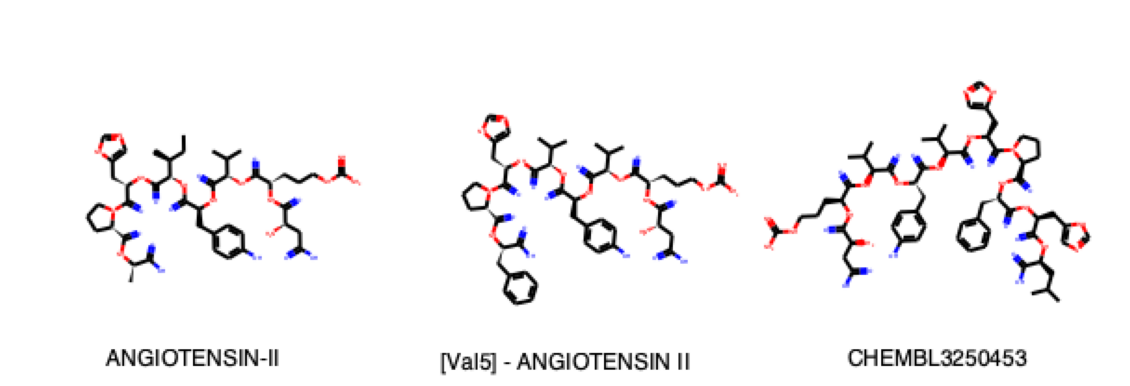


..................................................................................

Structure of trypsin


Sorry, structure not found in Chembl database.

..................................................................................

Structure of CP


Sorry, structure not found in Chembl database.

..................................................................................

Structure of chloroquine



interactive(children=(IntSlider(value=-1, description='confId', max=1, min=-3), Output()), _dom_classes=('widg…


Molecules that have at least 85% similarity with chloroquine



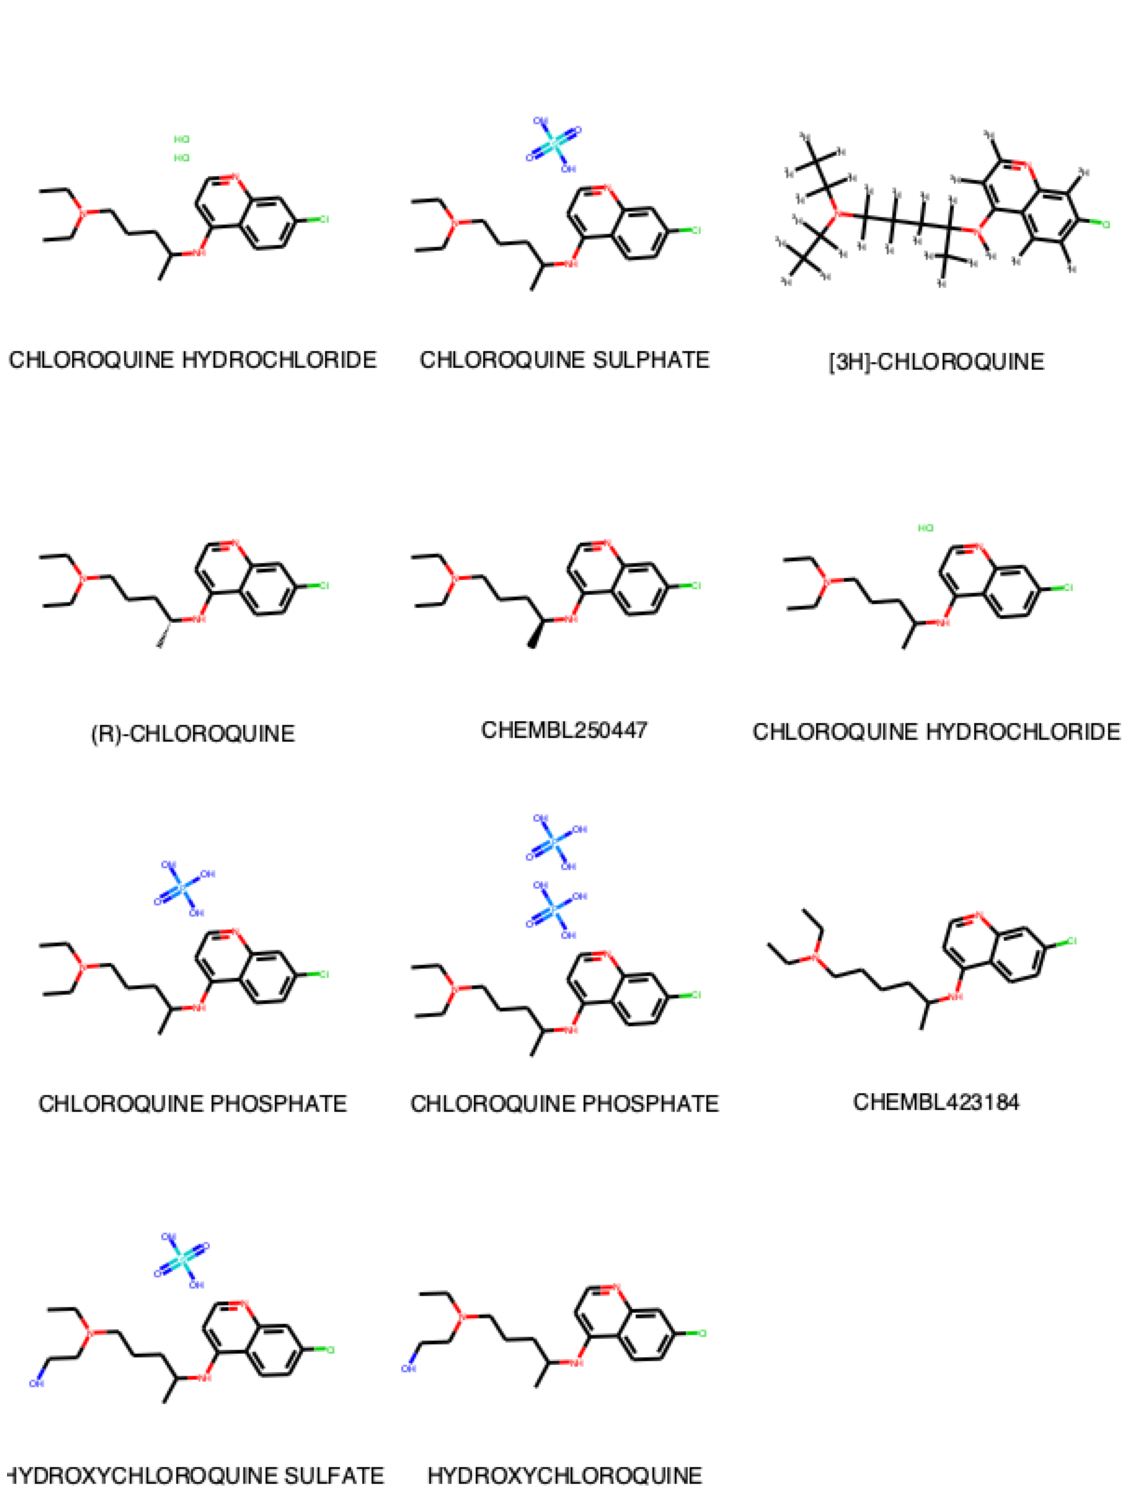


..................................................................................

Structure of lopinavir/ritonavir



interactive(children=(IntSlider(value=-1, description='confId', max=1, min=-3), Output()), _dom_classes=('widg…


Molecules that have at least 85% similarity with lopinavir/ritonavir



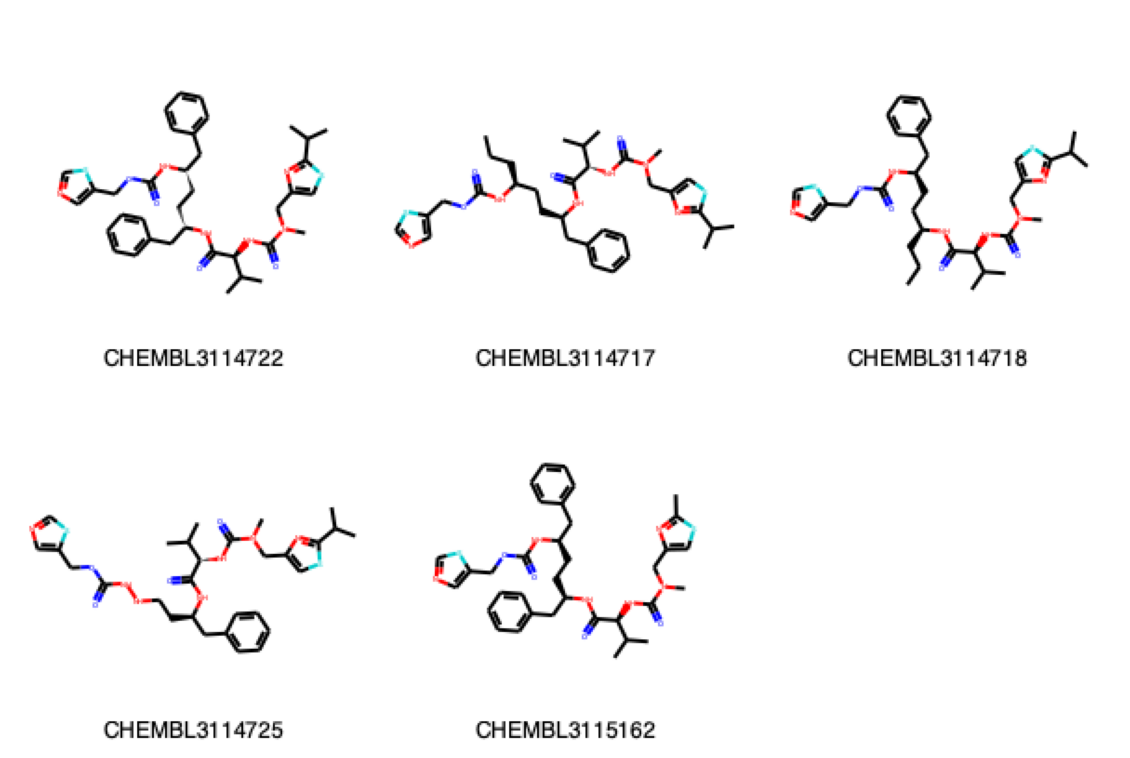

In [43]:
#hide_input
percentSimilarity = 85

for i in range(len(listchemicals)):
    try:
        productName = listchemicals[i]
        print('\n..................................................................................')
        print(f'\nStructure of {productName}\n')

        ################## Find the molecular structure in Chembl database ###########################
        
        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        # create the molecule image
        AllChem.EmbedMultipleConfs(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
        interact(drawit, m=fixed(m),p=fixed(p));
                
        ############ Find similar molecules in Chembl database ###################################### 
        print(f'\nMolecules that have at least {percentSimilarity}% similarity with {productName}\n')
        
        similarity = new_client.similarity
        similar = similarity.filter(chembl_id=molecule_chembl_id, similarity=percentSimilarity)

        list_mols=[]
        list_ref_name = []

        for i in range(len(similar)):

            ref_name = (similar[i]['pref_name'])
            if ref_name is None:
                ref_name = similar[i]['molecule_chembl_id']
#             print(ref_name)
            smileStruct = Chem.MolFromSmiles(similar[i]['molecule_structures']['canonical_smiles'])
            list_mols.append(smileStruct)
            list_ref_name.append(ref_name)

        ms = [x for x in list_mols if x is not None]

        for m in ms: tmp=AllChem.Compute2DCoords(m)

        img=Draw.MolsToGridImage(ms, molsPerRow=3,subImgSize=(200,200),legends=[x for x in list_ref_name])

        img.save('structures.png')
        image = cv2.imread('structures.png')        
        
        plt.figure(figsize=(20, 80))
        plt.ticklabel_format(style = 'plain')
        plt.axis('off')
        plt.imshow(image)
        plt.show()

    except Exception as e:
        print('\nSorry, structure not found in Chembl database.')
        


As a result we have a group of molecules structurally related to the researched compound.   
Such a result may be useful in further research in the search for potential new drugs.

# Conclusion

In this notebook we present a technique to analyse the documents provided in search of relevant information about drugs being developed.   

A method was developed to find the relevant files among those provided in the challenge.

Subsequently, a routine was developed whose objective is to find the words of interest as well as highlight them in the text and evaluate the context in which they are found. 

All of this allows the user to quickly and efficiently search various files of interest.

It was also evaluated the correlation of the molecular structure of the most mentioned compounds among themselves, through clustering.

Finally, the algorithm also searches the public CHEMBL database to find the chemical structure of the studied compound, as well as finding similar structures available in the database for further research by the user.


With the work it was possible to reach the following conclusions:

* Several articles cite therapeutics with the use of drugs from different classes, such as antiretroviral protease inhibitors, corticosteroids, polyene antibiotics, glycosaminoglycans heparan sulfate, proteases and aminoquinoline derivatives.
* There are 23 ongoing clinical trialsTRIALS in China. Chloroquine seems to be effective in limiting the replication of SARS-CoV-2 (virus causing COVID-19) in vitro.(https://www.sciencedirect.com/science/article/pii/S0883944120303907?via%3Dihub)
* Chloroquine was a highly effective treatment for falciparum malaria in The Gambia. High-grade resistance will soon preclude the use of chloroquine in severe malaria.(https://www.thelancet.com/journals/lancet/article/PII0140-6736(92)91645-O/fulltext) 
* (Chymo)trypsin-like serine fold proteases belong to the serine/cysteine proteases found in eukaryotes, prokaryotes, and viruses. For that reason, their catalytic activity is carried out using a triad of amino acids, a nucleophile, a base, and an acid. For this superfamily of proteases, they propose the existence of a universal 3D structure comprising 11 amino acids near the catalytic nucleophile and base -Nucleophile-Base Catalytic Zone (NBCZone).(https://www.sciencedirect.com/science/article/pii/S0141813019386854?via%3Dihub)
* The structure models of two severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) proteases, coronavirus endopeptidase C30 (CEP_C30) and papain like viral protease (PLVP), were built by homology modeling. Ritonavir, lopinavir and darunavir were then docked to the models, respectively, followed by energy minimization of the protease-drug complexes. In the simulations, ritonavir can bind to coronavirus endopeptidase C30 (CEP_C30)  most suitably, and induce significant conformation changes of CEP_C30; lopinavir can also bind to CEP_C30 suitably, and induce significant conformation changes of CEP_C30; darunavir can bind to PLVP suitably with slight conformation changes of PLVP. It is suggested that the therapeutic effect of ritonavir and lopinavir on COVID-19 may be mainly due to their inhibitory effect on CEP_C30, while ritonavirL may have stronger efficacy ; the inhibitory effect of darunavir on SARS-CoV-2 and its potential therapeutic effect may be mainly due to its inhibitory effect on PLVP. (https://www.biorxiv.org/content/10.1101/2020.01.31.929695v2)
* A total of 26 patients received intravenous administration of methylprednisolone with a dosage of 1-2mg/kg/d for 5-7 days, while the remaining patients not. The average number of days for body temperature back to the normal range was significantly shorter in patients with administration of methylprednisolone when compared to those without administration of methylprednisolone (2.06±0.28 vs. 5.29±0.70, P=0.010). The patients with administration of methylprednisolone had a faster improvement of SpO2, while patients without administration of methylprednisolone had a significantly longer interval of usingUSAGES supplemental oxygen therapy (8.2days[IQR 7.0-10.3] vs. 13.5days(IQR 10.3-16); P<0.001). In terms of chest CT, the absorption degree of the focus was significantly better in patients with administration of methylprednisolone. Our dataTRIALS indicate that in patients with severe COVID-19 pneumonia, early, lowdose and short-term application of corticosteroid was associated with a faster improvement of clinical symptoms and absorption of lung focus. (https://www.medrxiv.org/content/10.1101/2020.03.06.20032342v1)
*  It was studied the interaction between the SARS-CoV-2 Spike S1 protein receptor binding domain (SARS-CoV-2 S1 RBD) and heparin. The data demonstrate an interaction between the recombinant surface receptor binding domain and the polysaccharide. This has implications for the rapid development of a first-line therapeutic by repurposing heparin and for next-generation, tailor-made, GAG-based antivirals.(https://www.biorxiv.org/content/10.1101/2020.02.29.971093v1)



The results show that the technique can be used to gain important insights into the about drugs and therapeutics related to coronavirus pandemic, in an agile way and without having to read thousands of full papers.
 
## Pros and cons

About the technique used, we can highlight the ease and speed of obtaining the required information. 

As cons, we emphasize that depending on the number of files to be evaluated, the execution of the algorithm can take a while.